# Advances in Simulation Plotting and Performance

Throughout these teaching notebooks, we're going to take you step-by-step through the development and considerations we make when producing an simulation software that uses units.

In this notebook (**3**) we are going to cover:

- **[Visualizing Simulations](#s1)**
- **[Improvements to visualization; different teams](#s2)**
- **[Incorporating Direction](#s3)**
- **[Checking Current Scalable Performance](#s4)**
- **[Scalability between random and nearest](#s5)**

Click on any of the links to jump to that section.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, "../")
%matplotlib inline

import battlesim as bsm

## <a id='s1'> Visualizing Simulations

Thus far we have just plotted static quiver plots and plotted the health bars of `Unit` objects decrease as we step in time. One of the key motivations of this project is the development of sound animation plots for our Units as they traverse the game space.

To achieve this, we make use of the `matplotlib.animation` library which neatly provides functionality to handle changes to Matplotlib plots frame-by-frame. These frames can be compiled together to form images or gifs or other format.

In [2]:
db_ = bsm.legacy.import_db_file("../datasets/starwars-clonewars.csv")

We create our groups as before.

In [3]:
group1 = bsm.legacy.create_unit_group(db_, "Clone Trooper", 20, (0., 1.))
group2 = bsm.legacy.create_unit_group(db_, "B1 battledroid", 50, (10., 1.))
bsm.legacy.assign_enemies(group1+group2)
# run a simulation.
Res = bsm.legacy.basic_simulation3(group1+group2, 100)

### Frame-by frame interactions

When developing a function that can plot animations; there are a number of basic rules we have to follow:

1. The plot cannot shift on it's axis. Once it is set we do not change the x-y axis.
2. We need an `init` method to initialize what frame to start with
3. We need an `animate` method to set what data occupies a frame at frame $i$.

Take a look at the following implementation:

In [4]:
from matplotlib import animation


def set_boundary(ax, pos):
    xmin, xmax = np.min(pos[:, 0, :])-1., np.max(pos[:, 0, :])+1.
    ymin, ymax = np.min(pos[:, 1, :])-1., np.max(pos[:, 1, :])+1.
    # set bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    # hide axes labels
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

def basic_animate(results, n):
    
    # extract data points
    pos = bsm.legacy.extract_pos(results, n)
    
    plt.rcParams["animation.html"] = "html5"
    N_f = len(results)
    
    # define a figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    # define boundaries - we use a function
    set_boundary(ax, pos)
    
    # set the object to draw to
    u_points, = ax.plot([], [], 'x', color="black", alpha=.8, markersize=5.)
    
    fig.tight_layout()
    # close the plot
    plt.close()
    
    # define init
    def init():
        u_points.set_data(pos[0, 0, :], pos[0, 1, :])
        return u_points
    
    # define animate
    def animate(i):
        u_points.set_data(pos[i, 0, :], pos[i, 1, :])
        return u_points
    
    ani = animation.FuncAnimation(fig, animate, init_func=init, interval=100, frames=N_f, blit=False)
    plt.show()
    return ani

In [5]:
from IPython.display import HTML

#### It may take some tweaking of the parameters to get this to work on your system

For example I had to set `blit=False`, but it is usually true. 

Other parameters to try are:

- `basic_animate(Res, 40)`
- `HTML(basic_animate(Res, 40).to_jshtml())`
- `HTML(basic_animate(Res, 40).to_html5_video())`

In [6]:
HTML(basic_animate(Res, 70).to_html5_video())

### Initial problems...

1. We can't *differentiate* between teams, i.e Republic and CIS
2. It seems a bit fast...
3. It would be nice to know which units are alive and which ones have been wiped out.

BUT:

We have a **working simulation**!

## <a id='s2'> Improvement to visualization; different teams

This time, we'll include different teams by colour and differentiate between alive and dead units using a 'circle' for alive and 'cross' for dead.

In [7]:
def basic_animate2(results, n):
    
    N_f = len(results)
    # extract data points
    pos = bsm.legacy.extract_pos(results, n)
    hp = bsm.legacy.extract_hp(results, n)
    T = bsm.legacy.extract_team(results, n)
    
    T_uniq = np.unique(T)
    
    plt.rcParams["animation.html"] = "html5"

    
    # define a figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    # define boundaries - we use a function
    set_boundary(ax, pos)
    
    # create a colormap to map our team to a color - use the colorwheel
    cm = dict(zip(T_uniq, bsm.utils.colorwheel()))
    
    # set the objects to draw to - we set them into lists.
    points_alive = bsm.utils.toflat(
        [ax.plot([], [], 'o', color=cm[a], alpha=.6, markersize=10.) for a in T_uniq])
    points_dead = bsm.utils.toflat(
        [ax.plot([], [], 'x', color=cm[a], alpha=.4, markersize=5.) for a in T_uniq])
    
    fig.tight_layout()
    # close the plot
    plt.close()
    
    # define init
    def init():
        for j, a in enumerate(T_uniq):
            T_Alive = np.argwhere((hp[:, 0] > 0) & (T[:, 0]==a)).flatten()
            T_Dead = np.argwhere((hp[:, 0] <= 0) & (T[:, 0]==a)).flatten()
            
            if len(T_Alive) > 0:
                points_alive[j].set_data(pos[0, 0, T_Alive], pos[0, 1, T_Alive])
            if len(T_Dead) > 0:
                points_dead[j].set_data(pos[0, 0, T_Dead], pos[0, 1, T_Dead])
        return ((*points_alive, *points_dead))
    
    # define animate
    def animate(i):
        for j, a in enumerate(T_uniq):
            T_Alive = np.argwhere((hp[:, i] > 0) & (T[:, i]==a)).flatten()
            T_Dead = np.argwhere((hp[:, i] <= 0) & (T[:, i]==a)).flatten()
            
            if len(T_Alive) > 0:
                points_alive[j].set_data(pos[i, 0, T_Alive], pos[i, 1, T_Alive])
            if len(T_Dead) > 0:
                points_dead[j].set_data(pos[i, 0, T_Dead], pos[i, 1, T_Dead])
            
        return ((*points_alive, *points_dead))
    
    ani = animation.FuncAnimation(fig, animate, init_func=init, interval=100, frames=N_f, blit=False)
    plt.show()
    return ani

In [8]:
HTML(basic_animate2(Res,70).to_jshtml())

## <a id='s3'> One step further: Incorporating Direction

Rather than just represent alive units as a 'dot' on the screen, we can tell users which direction it is travelling using `quiver`.

In [9]:
def basic_animate3(results, n):
    
    N_f = len(results)
    # extract data points
    pos = bsm.legacy.extract_pos(results, n)
    dpos = bsm.legacy.extract_dpos(results, n)
    hp = bsm.legacy.extract_hp(results, n)
    T = bsm.legacy.extract_team(results, n)
    
    T_uniq = np.unique(T)
    
    plt.rcParams["animation.html"] = "html5"

    
    # define a figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    # define boundaries - we use a function
    set_boundary(ax, pos)
    
    # create a colormap to map our team to a color - use the colorwheel
    cm = dict(zip(T_uniq, bsm.utils.colorwheel()))
    
    
    # set the objects to draw to - we set them into lists.
    arrow_alive = []
    
    for j, a in enumerate(T_uniq):
        T_Alive0 = np.argwhere((hp[:, 0] > 0) & (T[:, 0]==a)).flatten()
        T_Dead0 = np.argwhere((hp[:, 0] <= 0) & (T[:, 0]==a)).flatten()
        
        alive = ax.quiver(pos[0, 0, T_Alive0], pos[0, 1, T_Alive0],
                          dpos[0, 0, T_Alive0], dpos[0, 1, T_Alive0],
                          color=cm[a], alpha=.5, scale=30, 
                          width=0.015, pivot="mid")
        arrow_alive.append(alive)
    
    points_dead = bsm.utils.toflat(
        [ax.plot([], [], 'x', color=cm[a], alpha=.4, markersize=5.) for a in T_uniq])
    
    # figure things
    fig.tight_layout()
    # close the plot
    plt.close()
    
    # define init
    def init():
        for j, a in enumerate(T_uniq):
            T_Alive = np.argwhere((hp[:, 0] > 0) & (T[:, 0]==a)).flatten()
            T_Dead = np.argwhere((hp[:, 0] <= 0) & (T[:, 0]==a)).flatten()
            
            if len(T_Alive) > 0:
                arrow_alive[j].set_UVC(dpos[0, 0, T_Alive], dpos[0, 1, T_Alive])
            if len(T_Dead) > 0:
                points_dead[j].set_data(pos[0, 0, T_Dead], pos[0, 1, T_Dead])
        return ((*arrow_alive, *points_dead))
    
    # define animate
    def animate(i):
        for j, a in enumerate(T_uniq):
            # get IDs of alive and dead units.
            T_Alive = np.argwhere((hp[:, i] > 0) & (T[:, i]==a)).flatten()
            T_Dead = np.argwhere((hp[:, i] <= 0) & (T[:, i]==a)).flatten()
            
            if len(T_Alive) > 0:
                # we #'set the offsets' i.e arrow position.
                arrow_alive[j].set_offsets(pos[i, :, T_Alive])
                # we set the directions of the arrows
                arrow_alive[j].set_UVC(dpos[i, 0, T_Alive], dpos[i, 1, T_Alive])
            if len(T_Dead) > 0:
                points_dead[j].set_data(pos[i, 0, T_Dead], pos[i, 1, T_Dead])
            
        return ((*arrow_alive, *points_dead))
    
    ani = animation.FuncAnimation(fig, animate, init_func=init, interval=100, frames=N_f, blit=False)
    plt.show()
    return ani

In [10]:
HTML(basic_animate3(Res,70).to_jshtml())

## <a id='s4'> Measuring Performance of Simulation

Here we would like to begin to analyse how the algorithm performs as we scale up the number of units within the simulation.

*WARNING*: This part can take an awful long time. Do reduce the parameters by a smidge if you wish to see results in a few seconds.

In [11]:
T = []
N = np.logspace(0, 3.5, 15, dtype=np.int).tolist()

for n in N:
    group1 = bsm.legacy.create_unit_group(db_, "Clone Trooper", n//3, (0., 1.))
    group2 = bsm.legacy.create_unit_group(db_, "B1 battledroid", (n//3)*2, (10., 1.))
    bsm.legacy.assign_enemies(group1+group2)
    t = bsm.utils.time_n(bsm.legacy.basic_simulation3, 3, group1+group2, 100)
    T.append(t)

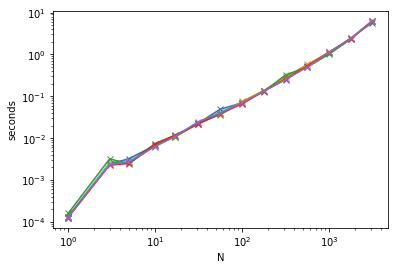

In [12]:
plt.loglog(N, T, 'x-')
plt.ylabel("seconds")
plt.xlabel("N")
plt.show()

We can already see that we are getting problems handling more than 100 units which is a *big problem*! This will lead to issues of **scalability** once we want to incorporate more advanced features.

### A different AI approach to targeting

For example, we may wish to instead get *units to target their nearest enemy* once their target has died. Mathematically in 2-dimensions we would describe this as:

$$
T_i = \arg \min \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2} \quad \forall j
$$

where $T_i$ is the index of the $j$th targeted unit for the use of unit $i$. Note that this space should only be searched among *alive* units for computational efficiency. This is equivalent to the **euclidean distance** metric.


We would implement the following simulation:

In [13]:
def find_nearest_enemy(u, units):
    # get the alive units, and calculate the euclidean distance from them.
    alive_enemies = [i for i in units if (i.hp > 0) and (i.team != u.team)]
    if len(alive_enemies) > 0:
        D = np.asarray([bsm.legacy.euclidean(u.pos, i.pos) for i in alive_enemies])
        return alive_enemies[np.argmin(D)]
    else:
        return -1

In [14]:
from copy import deepcopy

def basic_simulation4(units, max_step=50):
    # create a copy of the units
    units = deepcopy(units)
    # begin t
    t = 0
    running = True

    steps = []

    # while loop
    while running and (t < max_step):
        # iterate over units.
        for i, u in enumerate(units):
            #if we're alive...
            if u.hp > 0:

                # wait a second. what if our enemy is dead..?
                if u.target.hp <= 0.:
                    # find a new random enemy.
                    target = find_nearest_enemy(u, units)
                    if target != -1:
                        u.target = target
                    else:
                        # no more enemies - stop!
                        running = False

                """Only do all this once we have a valid target..."""
                # euclidean distance
                u.dd = bsm.legacy.deriv_norm(u.pos, u.target.pos)
                u.dist = bsm.legacy.euclidean(u.pos, u.target.pos)
                # now, if the unit is not in range, then move towards it
                if u.dist > u.range:
                    # speed modifier added, others ignored from above.
                    u.pos += bsm.legacy.dudt(u.pos, u.target.pos, u.speed)
                else:
                    # perform damage to enemy health.
                    u.target.hp -= u.dmg

        # save
        steps.append(deepcopy(units))
        # add step
        t += 1

    return steps

In [15]:
group1 = bsm.legacy.create_unit_group(db_, "Clone Trooper", 20, (0., 1.))
group2 = bsm.legacy.create_unit_group(db_, "B1 battledroid", 50, (10., 1.))
bsm.legacy.assign_enemies(group1+group2)
# run a simulation.
Res = basic_simulation4(group1+group2, 100)

#### Running the nearest-neighbours algorithm.

In [16]:
HTML(basic_animate3(Res,70).to_jshtml())

### <a id='s5'> Scalability between `random` and `nearest` selection
    
We go back now to comparing the performance between random and nearest selection to see the impact on performance metrics.

In [17]:
nruns = 15
repeats = 3
T_rand, T_near = np.empty((nruns,repeats)), np.empty((nruns,repeats))
N = np.logspace(0, 3.5, nruns, dtype=np.int).tolist()

for i, n in enumerate(N):
    group1 = bsm.legacy.create_unit_group(db_, "Clone Trooper", n//3, (0., 1.))
    group2 = bsm.legacy.create_unit_group(db_, "B1 battledroid", (n//3)*2, (10., 1.))
    bsm.legacy.assign_enemies(group1+group2)
    T_rand[i, :] = bsm.utils.time_n(bsm.legacy.basic_simulation3, repeats, group1+group2, 100)
    T_near[i, :] = bsm.utils.time_n(basic_simulation4, repeats, group1+group2, 100)

Here we can clearly see that in the higher orders of magnitude, the `nearest` algorithm, although behaving more naturally, is actually less computationally efficient than choosing a random enemy. And this difference only diverges the higher we go in performance times.

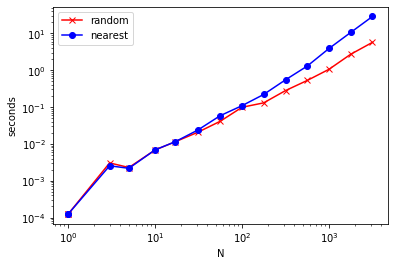

In [22]:
plt.loglog(N, T_rand.mean(axis=1), 'x-',color="red", label="random")
plt.loglog(N, T_near.mean(axis=1), 'o-', color="blue", label="nearest")
plt.ylabel("seconds")
plt.xlabel("N")
plt.legend()
plt.show()

This marks the end of this particular notebook. I hope you have learnt some interesting things and please continue on to the next study.